In [1]:
import sys
sys.path.insert(0, '/Users/jaswantjonnada/Documents/TestRequestForm/src')

from image_align import SIFTAligner, ORBAligner
from data_extraction import BoxDataExtractor, MorphDataExtractor
from matplotlib import pyplot as plt
import cv2
import os
import numpy as np
import json
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer
from sklearn.metrics import hamming_loss, accuracy_score

## Information Extraction

Extracting Information from the annotations and ROI

Also, creating the extractors

In [2]:
roi_data = "/Users/jaswantjonnada/Documents/TestRequestForm/roi_data/TRF-1_annotation.json"

box_extractor = BoxDataExtractor(roi_data)

lifecell_template_path = "/Users/jaswantjonnada/Documents/TestRequestForm/templates/TRF-1.png"

sift_aligner = SIFTAligner(lifecell_template_path)

Creating an extract data function, so that the labeling is consistent in the annotations and ROI Information

In [3]:
def extract_data(im, aligner, extractor):
    query = cv2.imread(im)
    aligned_sift = aligner.align(query)

    entities = extractor.extract(aligned_sift)
    corrected_entites = []
    for entity in entities:
        #Recurrent Pregnancy Loss (RPL without KT) without LA/APTT
        if (entity == "Recurrent Pregnancy Loss (RPL without KT) without LA/APTT") or (entity == "Recurrent Pregnancy Loss (RPL with KT) without LA/APTT"):
            corrected_entites.append("without LA/APTT")
        elif (entity == "BOH without LA"):
            corrected_entites.append("without LA")
        else:
            corrected_entites.append(entity)

    return corrected_entites

Extracting some sample images

In [4]:
lifecell_im_dir = "/Users/jaswantjonnada/Documents/TestRequestForm/data_1/images/lifecell-1"

sample_query_image_1 = os.path.join(lifecell_im_dir, "image_snap_1660127751857.jpeg")
sample_query_image_2 = os.path.join(lifecell_im_dir, "image_snap_1660127845671.jpeg")

Checking the alignment of the sample Images

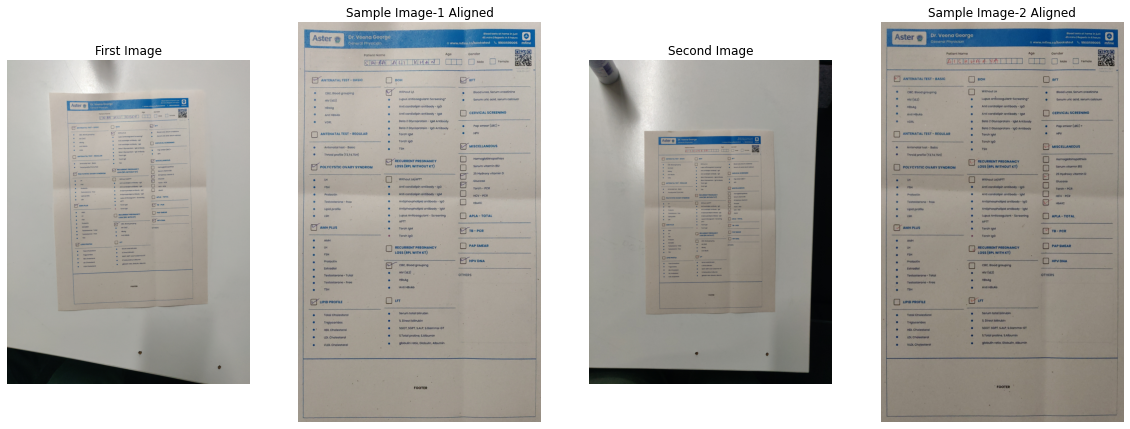

In [5]:
sample_query_1 = cv2.imread(sample_query_image_1)
sample_query_2 = cv2.imread(sample_query_image_2)

aligned_1 = sift_aligner.align(sample_query_1)
aligned_2 = sift_aligner.align(sample_query_2)

plt.figure(figsize=(20, 20))

ax1 = plt.subplot(141)
ax1.axis('off')
ax1.set_title('First Image')
ax1.imshow(cv2.cvtColor(sample_query_1, cv2.COLOR_BGR2RGB), cmap=plt.cm.gray)

ax2 = plt.subplot(142)
ax2.axis('off')
ax2.set_title('Sample Image-1 Aligned')
ax2.imshow(cv2.cvtColor(aligned_1, cv2.COLOR_BGR2RGB), cmap=plt.cm.gray)

ax3 = plt.subplot(143)
ax3.axis('off')
ax3.set_title('Second Image')
ax3.imshow(cv2.cvtColor(sample_query_2, cv2.COLOR_BGR2RGB), cmap=plt.cm.gray)

ax4 = plt.subplot(144)
ax4.axis('off')
ax4.set_title('Sample Image-2 Aligned')
ax4.imshow(cv2.cvtColor(aligned_2, cv2.COLOR_BGR2RGB), cmap=plt.cm.gray)

In [6]:
print("---First-----")
print(box_extractor.extract(aligned_1))
print("---Second---")
print(box_extractor.extract(aligned_image=aligned_2))

---First-----
['Antenatal Test - Regular', 'Polycystic Ovary Syndrome', 'AMH Plus', 'Lipid Profile', 'BOH ', 'BOH without LA', 'Recurrent Pregnancy Loss (RPL without KT)', 'Recurrent Pregnancy Loss (RPL without KT) without LA/APTT', 'Recurrent Pregnancy Loss (RPL with KT)', 'CBC, Blood grouping', 'LFT', 'RFT', 'Cervical Screening', 'Misceullaneous', 'Hemoglobinopathies', 'Serum Vitamin B12', '25 Hydroxy Vitamin D ', 'Glucose', 'TORCH - PCR', 'HCV - PCR', 'APLA-TOTAL', 'TB-PCR', 'Pap Smear', 'HPV DNA']
---Second---
['Antenatal Test - Regular', 'Polycystic Ovary Syndrome', 'AMH Plus', 'Lipid Profile', 'BOH ', 'BOH without LA', 'Recurrent Pregnancy Loss (RPL without KT)', 'Recurrent Pregnancy Loss (RPL without KT) without LA/APTT', 'Recurrent Pregnancy Loss (RPL with KT)', 'CBC, Blood grouping', 'LFT', 'RFT', 'Cervical Screening', 'Misceullaneous', 'Hemoglobinopathies', 'Serum Vitamin B12', '25 Hydroxy Vitamin D ', 'Glucose', 'TORCH - PCR', 'HCV - PCR', 'APLA-TOTAL', 'TB-PCR', 'Pap Smear'

In [7]:
sample_query_entities_1 = extract_data(sample_query_image_1, sift_aligner, box_extractor)
sample_query_entities_2 = extract_data(sample_query_image_2, sift_aligner, box_extractor)

print(sample_query_entities_1)
print(sample_query_entities_2)

['Antenatal Test - Regular', 'Polycystic Ovary Syndrome', 'AMH Plus', 'Lipid Profile', 'BOH ', 'without LA', 'Recurrent Pregnancy Loss (RPL without KT)', 'without LA/APTT', 'Recurrent Pregnancy Loss (RPL with KT)', 'CBC, Blood grouping', 'LFT', 'RFT', 'Cervical Screening', 'Misceullaneous', 'Hemoglobinopathies', 'Serum Vitamin B12', '25 Hydroxy Vitamin D ', 'Glucose', 'TORCH - PCR', 'HCV - PCR', 'APLA-TOTAL', 'TB-PCR', 'Pap Smear', 'HPV DNA']
['Antenatal Test - Regular', 'Polycystic Ovary Syndrome', 'AMH Plus', 'Lipid Profile', 'BOH ', 'without LA', 'Recurrent Pregnancy Loss (RPL without KT)', 'without LA/APTT', 'Recurrent Pregnancy Loss (RPL with KT)', 'CBC, Blood grouping', 'LFT', 'RFT', 'Cervical Screening', 'Misceullaneous', 'Hemoglobinopathies', 'Serum Vitamin B12', '25 Hydroxy Vitamin D ', 'Glucose', 'TORCH - PCR', 'HCV - PCR', 'APLA-TOTAL', 'TB-PCR', 'Pap Smear', 'HPV DNA']


### Reading Annotations

In [8]:
annotated_json = '/Users/jaswantjonnada/Documents/TestRequestForm/data_1/2022_32.json'

with open(annotated_json, 'rb') as annotated_json_file:
    annotated_data = json.load(annotated_json_file)

In [9]:
sample = annotated_data[0]
sample

{'task_id': 'lab_form',
 'batch_id': '2022_32',
 'data': 'http://ai.mfine.int/api/contentservice/attachments/downloadFromDb?fileName=snapmmd/image_snap_1660127120112.jpeg',
 'label': {'rotate_state': '',
  'new_url': '',
  'bbs': [{'label': 'BOH ',
    'bb': [34.96621621621622,
     28.625712476250794,
     2.195945945945944,
     1.2666244458518037]},
   {'label': 'Antenatal Test - Regular',
    'bb': [24.239864864864867,
     38.948701709943,
     1.9425675675675684,
     1.456618112729572]},
   {'label': 'Polycystic Ovary Syndrome',
    'bb': [26.013513513513516,
     43.38188727042432,
     1.9425675675675649,
     1.456618112729572]},
   {'label': 'Lipid Profile',
    'bb': [32.85472972972973,
     62.064597846738444,
     2.195945945945944,
     1.2032932235592142]},
   {'label': 'Pap Smear',
    'bb': [57.34797297297297,
     48.38505383153895,
     1.942567567567572,
     1.4566181127295792]},
   {'label': 'HPV DNA',
    'bb': [58.192567567567565,
     50.47498416719443,
     1

In [10]:
for data in annotated_data:
    filename = data['data'].split('/')[-1]

    if filename == 'image_snap_1660127751857.jpeg':
        for bb in data['label']['bbs']:
            print(bb['label'])

Lipid Profile
AMH Plus
CBC, Blood grouping
HPV DNA
TB-PCR
Misceullaneous
25 Hydroxy Vitamin D 
Glucose
Recurrent Pregnancy Loss (RPL without KT)
Polycystic Ovary Syndrome
RFT
without LA
Antenatal Test - Basic


Comparing between lifecell tagged labels on the annotation data, and tagging on the templates

In [11]:
annotated_names = set()

lifecell_images = os.listdir("/Users/jaswantjonnada/Documents/TestRequestForm/data_1/images/lifecell-1")

for data in annotated_data:
    filename = data['data'].split('/')[-1]

    if filename in lifecell_images:
        for bb in data['label']['bbs']:
            annotated_names.add(bb['label'])

In [12]:
annotated_names

{'25 Hydroxy Vitamin D ',
 'AMH Plus',
 'APLA-TOTAL',
 'Antenatal Test - Basic',
 'Antenatal Test - Regular',
 'BOH ',
 'CBC, Blood grouping',
 'Cervical Screening',
 'Glucose',
 'HCV - PCR',
 'HPV DNA',
 'Hemoglobinopathies',
 'LFT',
 'Lipid Profile',
 'Misceullaneous',
 'Pap Smear',
 'Polycystic Ovary Syndrome',
 'RFT',
 'Recurrent Pregnancy Loss (RPL with KT)',
 'Recurrent Pregnancy Loss (RPL without KT)',
 'Serum Vitamin B12',
 'TB-PCR',
 'TORCH - PCR',
 'without LA',
 'without LA/APTT'}

In [13]:
with open(roi_data, 'rb') as roi_data_json:
    roi_info = json.load(roi_data_json)



In [14]:
regions = [reg['region_attributes']['type'] for reg in roi_info['data']['regions']]
    # for r in region['region_attributes']:
    #     print(r['type'])
    # print(region['region_attributes'])

for reg in regions:
    if reg in annotated_names:
        print(f'Present in VGG Annotated: {reg}')
    else:
        print(f'Not Present in VGG Annotated: {reg}')



Present in VGG Annotated: Antenatal Test - Basic
Present in VGG Annotated: Antenatal Test - Regular
Present in VGG Annotated: Polycystic Ovary Syndrome
Present in VGG Annotated: AMH Plus
Present in VGG Annotated: Lipid Profile
Present in VGG Annotated: BOH 
Not Present in VGG Annotated: BOH without LA
Present in VGG Annotated: Recurrent Pregnancy Loss (RPL without KT)
Not Present in VGG Annotated: Recurrent Pregnancy Loss (RPL without KT) without LA/APTT
Present in VGG Annotated: Recurrent Pregnancy Loss (RPL with KT)
Present in VGG Annotated: CBC, Blood grouping
Present in VGG Annotated: LFT
Present in VGG Annotated: RFT
Present in VGG Annotated: Cervical Screening
Present in VGG Annotated: Misceullaneous
Present in VGG Annotated: Hemoglobinopathies
Present in VGG Annotated: Serum Vitamin B12
Present in VGG Annotated: 25 Hydroxy Vitamin D 
Present in VGG Annotated: Glucose
Present in VGG Annotated: TORCH - PCR
Present in VGG Annotated: HCV - PCR
Present in VGG Annotated: APLA-TOTAL
Pr

## Extracting the annotated data


In [15]:

annotated_labels = []

lifecell_im_dir = "/Users/jaswantjonnada/Documents/TestRequestForm/data_1/images/lifecell-1"

lifecell_images = os.listdir(lifecell_im_dir)

lifecell_image_list_for_evaluation = []
for data in annotated_data:
    filename = data['data'].split('/')[-1]

    if filename in lifecell_images:
        lifecell_image_list_for_evaluation.append(filename)
        annotated_labels.append([bb['label'] for bb in data['label']['bbs']])

# annotated_labels = np.array(annotated_labels
            

Creating a MultiLabel Binarizer

In [16]:
mlb = MultiLabelBinarizer()

Fitting the multilabel binarizer on the annotated data

In [17]:
mlb.fit(annotated_labels)

MultiLabelBinarizer()

Transforming annotated data

In [18]:
annotated_label_transformed = mlb.transform(annotated_labels)

In [19]:
annotated_label_transformed.shape

(18, 25)

Verifying the Multilabel Binarizer Transformation on sample queries

In [20]:
mlb.transform([sample_query_entities_1, sample_query_entities_2])

array([[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1],
       [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1]])

## Checking the metrics for the Box Extractor

Generating the test data set, 

Extracting entities for all Lifecell images

In [21]:
extracted_entities = []

for i, query_image in enumerate(lifecell_image_list_for_evaluation):
    query_image_path = os.path.join(lifecell_im_dir, query_image)
    entity = extract_data(query_image_path, sift_aligner, box_extractor)

    extracted_entities.append(entity)
    print(f'Image: {query_image}, annotated: {annotated_labels[i]}, extracted: {entity}')
    # extracted_entities.append(extract_data(query_image_path))

Image: image_snap_1660127120112.jpeg, annotated: ['BOH ', 'Antenatal Test - Regular', 'Polycystic Ovary Syndrome', 'Lipid Profile', 'Pap Smear', 'HPV DNA'], extracted: ['Antenatal Test - Basic', 'Antenatal Test - Regular', 'Polycystic Ovary Syndrome', 'AMH Plus', 'Lipid Profile', 'BOH ', 'without LA', 'Recurrent Pregnancy Loss (RPL without KT)', 'without LA/APTT', 'Recurrent Pregnancy Loss (RPL with KT)', 'CBC, Blood grouping', 'LFT', 'RFT', 'Cervical Screening', 'Misceullaneous', 'Hemoglobinopathies', 'Serum Vitamin B12', '25 Hydroxy Vitamin D ', 'Glucose', 'TORCH - PCR', 'HCV - PCR', 'APLA-TOTAL', 'TB-PCR', 'Pap Smear', 'HPV DNA']
Image: image_snap_1660127148561.jpeg, annotated: ['LFT', 'BOH ', 'without LA', 'Antenatal Test - Regular', 'Polycystic Ovary Syndrome', 'Cervical Screening', 'Hemoglobinopathies', 'Glucose', 'APLA-TOTAL', 'TB-PCR', 'Pap Smear', 'Recurrent Pregnancy Loss (RPL with KT)', 'AMH Plus', 'CBC, Blood grouping'], extracted: ['Antenatal Test - Basic', 'Antenatal Test

In [22]:
extracted_labels_transformed = mlb.transform(extracted_entities)

In [23]:
annotated_label_transformed[0]

array([0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0])

In [24]:
extracted_labels_transformed[0]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1])

In [25]:
def hamming_score(y_true, y_pred):


    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        acc_list.append(tmp_a)
    
    return np.mean(acc_list)


In [26]:
print('Metrics for Box Extractor')
print(f'Hamming Score: {hamming_score(annotated_label_transformed, extracted_labels_transformed):0.2f}')
print(f'Accuracy Score: {accuracy_score(annotated_label_transformed, extracted_labels_transformed):0.2f}')
print(f'Hamming Loss: {hamming_loss(annotated_label_transformed, extracted_labels_transformed):0.2f}')

Metrics for Box Extractor
Hamming Score: 0.37
Accuracy Score: 0.00
Hamming Loss: 0.62


## Checking the metrics for Morph Data Extractor

In [27]:
from data_extraction import MorphDataExtractor

In [28]:
mde = MorphDataExtractor(roi_data)

In [29]:
extract_data(sample_query_image_1, sift_aligner, mde)

['Antenatal Test - Basic',
 'Polycystic Ovary Syndrome',
 'AMH Plus',
 'Lipid Profile',
 'without LA',
 'Recurrent Pregnancy Loss (RPL without KT)',
 'CBC, Blood grouping',
 'RFT',
 'Misceullaneous',
 '25 Hydroxy Vitamin D ',
 'Glucose',
 'TB-PCR',
 'HPV DNA']

In [30]:
extracted_entities = []

for i, query_image in enumerate(lifecell_image_list_for_evaluation):
    query_image_path = os.path.join(lifecell_im_dir, query_image)
    entity = extract_data(query_image_path, sift_aligner, mde)

    extracted_entities.append(entity)
    print(f'Image: {query_image}, annotated: {annotated_labels[i]}, extracted: {entity}')
    # extracted_entities.append(extract_data(query_image_path))

Image: image_snap_1660127120112.jpeg, annotated: ['BOH ', 'Antenatal Test - Regular', 'Polycystic Ovary Syndrome', 'Lipid Profile', 'Pap Smear', 'HPV DNA'], extracted: ['Antenatal Test - Regular', 'Polycystic Ovary Syndrome', 'Lipid Profile', 'BOH ', 'Pap Smear', 'HPV DNA']
Image: image_snap_1660127148561.jpeg, annotated: ['LFT', 'BOH ', 'without LA', 'Antenatal Test - Regular', 'Polycystic Ovary Syndrome', 'Cervical Screening', 'Hemoglobinopathies', 'Glucose', 'APLA-TOTAL', 'TB-PCR', 'Pap Smear', 'Recurrent Pregnancy Loss (RPL with KT)', 'AMH Plus', 'CBC, Blood grouping'], extracted: ['Polycystic Ovary Syndrome', 'AMH Plus', 'BOH ', 'without LA', 'Recurrent Pregnancy Loss (RPL with KT)', 'CBC, Blood grouping', 'LFT', 'Cervical Screening', 'Hemoglobinopathies', 'Glucose', 'APLA-TOTAL', 'TB-PCR', 'Pap Smear']
Image: image_snap_1660127177456.jpeg, annotated: ['BOH ', 'without LA', 'Polycystic Ovary Syndrome', 'AMH Plus', 'LFT', 'TB-PCR', 'APLA-TOTAL', 'Cervical Screening'], extracted: ['

In [31]:
extracted_labels_transformed = mlb.transform(extracted_entities)

In [32]:
print('Metrics for Morph Data Extractor')
print(f'Hamming Score: {hamming_score(annotated_label_transformed, extracted_labels_transformed):0.2f}')
print(f'Accuracy Score: {accuracy_score(annotated_label_transformed, extracted_labels_transformed):0.2f}')
print(f'Hamming Loss: {hamming_loss(annotated_label_transformed, extracted_labels_transformed):0.2f}')

Metrics for Morph Data Extractor
Hamming Score: 0.90
Accuracy Score: 0.50
Hamming Loss: 0.04


## Evaluation on MFINE Forms

Checking the MFINE ROI with Annotations

In [33]:
lifecell_2_im_dir = "/Users/jaswantjonnada/Documents/TestRequestForm/data_1/images/lifecell-2"



In [34]:
lifecell_2_annotated_names = set()

lifecell_2_images = os.listdir(lifecell_2_im_dir)

for data in annotated_data:
    filename = data['data'].split('/')[-1]

    if filename in lifecell_2_images:
        for bb in data['label']['bbs']:
            lifecell_2_annotated_names.add(bb['label'].strip())

In [35]:
lifecell_2_annotated_names

{'25 Hydroxy Vitamin D',
 'AMH Plus',
 'APLA-TOTAL',
 'Antenatal Test - Basic',
 'Antenatal Test - Regular',
 'BOH',
 'CBC, Blood grouping',
 'Cervical Screening',
 'Glucose',
 'HCV - PCR',
 'HPV DNA',
 'Hemoglobinopathies',
 'LFT',
 'Lipid Profile',
 'Misceullaneous',
 'Pap Smear',
 'Polycystic Ovary Syndrome',
 'RFT',
 'Recurrent Pregnancy Loss (RPL with KT)',
 'Recurrent Pregnancy Loss (RPL without KT)',
 'Serum Vitamin B12',
 'TB-PCR',
 'TORCH - PCR',
 'without LA',
 'without LA/APTT'}

In [36]:
lifecell_2_roi_data = "/Users/jaswantjonnada/Documents/TestRequestForm/roi_data/TRF_annotation.json"
with open(lifecell_2_roi_data, 'rb') as roi_data_json:
    lifecell_2_roi_info = json.load(roi_data_json)



Checking to see if the annotation spellings and the ROI Spellings are correct

In [37]:
lifecell_2_regions = [reg['region_attributes']['type'] for reg in lifecell_2_roi_info['data']['regions']]
    # for r in region['region_attributes']:
    #     print(r['type'])
    # print(region['region_attributes'])

for reg in lifecell_2_regions:
    reg_strip = reg.strip()
    if reg_strip in lifecell_2_annotated_names:
        print(f'Present in VGG Annotated: {reg}')
    else:
        print(f'Not Present in VGG Annotated: {reg}')

Present in VGG Annotated: Antenatal Test - Basic
Present in VGG Annotated: Antenatal Test - Regular
Present in VGG Annotated: Polycystic Ovary Syndrome
Present in VGG Annotated: AMH Plus
Present in VGG Annotated: Lipid Profile
Present in VGG Annotated: BOH 
Not Present in VGG Annotated: BOH without LA
Present in VGG Annotated: Recurrent Pregnancy Loss (RPL without KT)
Not Present in VGG Annotated: Recurrent Pregnancy Loss (RPL without KT) without LA/APTT
Present in VGG Annotated: Recurrent Pregnancy Loss (RPL with KT)
Present in VGG Annotated: CBC, Blood grouping
Present in VGG Annotated: LFT
Present in VGG Annotated: RFT
Present in VGG Annotated: Cervical Screening
Present in VGG Annotated: Misceullaneous
Present in VGG Annotated: Hemoglobinopathies
Present in VGG Annotated: Serum Vitamin B12
Present in VGG Annotated: 25 Hydroxy Vitamin D 
Present in VGG Annotated: Glucose
Present in VGG Annotated: TORCH - PCR
Present in VGG Annotated: HCV - PCR
Present in VGG Annotated: APLA-TOTAL
Pr

In [38]:
lifecell_2_template_path = "/Users/jaswantjonnada/Documents/TestRequestForm/templates/TRF.png"

lifecell_2_sift_aligner = SIFTAligner(lifecell_2_template_path)

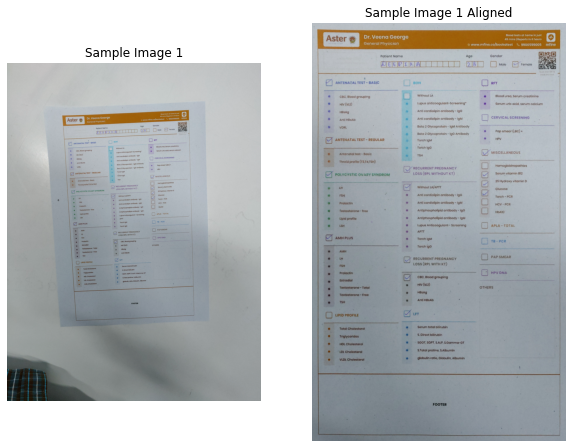

In [39]:
lifecell_2_sample_image_path = os.path.join(lifecell_2_im_dir, "image_snap_1660127444382.jpeg")
lifecell_2_sample_image = cv2.imread(lifecell_2_sample_image_path)

lifecell_2_sample_image_aligned = lifecell_2_sift_aligner.align(lifecell_2_sample_image)

plt.figure(figsize=(10,10))

ax1 = plt.subplot(121)
ax1.set_title("Sample Image 1")
ax1.axis('off')
ax1.imshow(lifecell_2_sample_image)

ax2 = plt.subplot(122)
ax2.set_title("Sample Image 1 Aligned")
ax2.axis('off')
ax2.imshow(lifecell_2_sample_image_aligned)

In [40]:
lifecell_2_mde = MorphDataExtractor(lifecell_2_roi_data)

In [41]:
extract_data(lifecell_2_sample_image_path, lifecell_2_sift_aligner, lifecell_2_mde)

['Antenatal Test - Basic',
 'Antenatal Test - Regular',
 'Polycystic Ovary Syndrome',
 'AMH Plus',
 'Recurrent Pregnancy Loss (RPL without KT)',
 'without LA/APTT',
 'Recurrent Pregnancy Loss (RPL with KT)',
 'CBC, Blood grouping',
 'LFT',
 'Misceullaneous',
 'Serum Vitamin B12',
 '25 Hydroxy Vitamin D ',
 'Glucose']

In [42]:

annotated_labels_lifecell_2 = []

lifecell_2_im_dir = "/Users/jaswantjonnada/Documents/TestRequestForm/data_1/images/lifecell-2"

lifecell_2_images = os.listdir(lifecell_2_im_dir)

lifecell_2_image_list_for_evaluation = []
for data in annotated_data:
    filename = data['data'].split('/')[-1]

    if filename in lifecell_2_images:
        lifecell_2_image_list_for_evaluation.append(filename)
        annotated_labels_lifecell_2.append([bb['label'] for bb in data['label']['bbs']])

In [43]:
annotated_labels_lifecell_2

[['RFT',
  'Cervical Screening',
  'Antenatal Test - Basic',
  'Antenatal Test - Regular',
  'Polycystic Ovary Syndrome'],
 ['RFT',
  'Cervical Screening',
  'BOH ',
  'without LA',
  'Recurrent Pregnancy Loss (RPL without KT)',
  'without LA/APTT',
  'Polycystic Ovary Syndrome',
  'AMH Plus',
  'Recurrent Pregnancy Loss (RPL with KT)',
  'CBC, Blood grouping'],
 ['Antenatal Test - Basic',
  'Antenatal Test - Regular',
  'RFT',
  'AMH Plus',
  'Lipid Profile',
  'LFT'],
 ['Lipid Profile',
  'LFT',
  'Recurrent Pregnancy Loss (RPL with KT)',
  'HPV DNA',
  'Pap Smear',
  'Recurrent Pregnancy Loss (RPL without KT)',
  'Antenatal Test - Regular',
  'Antenatal Test - Basic'],
 ['LFT',
  'Lipid Profile',
  'Hemoglobinopathies',
  'Serum Vitamin B12',
  '25 Hydroxy Vitamin D ',
  'RFT'],
 ['Misceullaneous',
  'Serum Vitamin B12',
  '25 Hydroxy Vitamin D ',
  'Glucose',
  'without LA/APTT',
  'Recurrent Pregnancy Loss (RPL without KT)',
  'AMH Plus',
  'Polycystic Ovary Syndrome',
  'Recurren

In [44]:
annotated_label_lifecell_2_transformed = mlb.transform(annotated_labels_lifecell_2)
annotated_label_lifecell_2_transformed[0]

array([0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0])

In [45]:
extracted_entities_lifecell_2 = []

for i, query_image in enumerate(lifecell_2_image_list_for_evaluation):
    query_image_path = os.path.join(lifecell_2_im_dir, query_image)
    entity = extract_data(query_image_path, lifecell_2_sift_aligner, lifecell_2_mde)

    extracted_entities_lifecell_2.append(entity)
    print(f'Image: {query_image}, annotated: {annotated_labels_lifecell_2[i]}, extracted: {entity}')

Image: image_snap_1660127308212.jpeg, annotated: ['RFT', 'Cervical Screening', 'Antenatal Test - Basic', 'Antenatal Test - Regular', 'Polycystic Ovary Syndrome'], extracted: ['Antenatal Test - Basic', 'Antenatal Test - Regular', 'Polycystic Ovary Syndrome', 'RFT', 'Cervical Screening']
Image: image_snap_1660127340200.jpeg, annotated: ['RFT', 'Cervical Screening', 'BOH ', 'without LA', 'Recurrent Pregnancy Loss (RPL without KT)', 'without LA/APTT', 'Polycystic Ovary Syndrome', 'AMH Plus', 'Recurrent Pregnancy Loss (RPL with KT)', 'CBC, Blood grouping'], extracted: ['Polycystic Ovary Syndrome', 'AMH Plus', 'BOH ', 'without LA', 'Recurrent Pregnancy Loss (RPL without KT)', 'without LA/APTT', 'Recurrent Pregnancy Loss (RPL with KT)', 'CBC, Blood grouping', 'RFT', 'Cervical Screening']
Image: image_snap_1660127370484.jpeg, annotated: ['Antenatal Test - Basic', 'Antenatal Test - Regular', 'RFT', 'AMH Plus', 'Lipid Profile', 'LFT'], extracted: ['Antenatal Test - Basic', 'Antenatal Test - Regu

In [46]:
extracted_labels_lifecell_2_transformed = mlb.transform(extracted_entities_lifecell_2)



In [47]:
print('Metrics for Morph Data Extractor -  for Mfine Data')
print(f'Hamming Score: {hamming_score(annotated_label_lifecell_2_transformed, extracted_labels_lifecell_2_transformed):0.2f}')
print(f'Accuracy Score: {accuracy_score(annotated_label_lifecell_2_transformed, extracted_labels_lifecell_2_transformed):0.2f}')
print(f'Hamming Loss: {hamming_loss(annotated_label_lifecell_2_transformed, extracted_labels_lifecell_2_transformed):0.2f}')

Metrics for Morph Data Extractor -  for Mfine Data
Hamming Score: 0.79
Accuracy Score: 0.67
Hamming Loss: 0.07


## Using Fallback Aligner Method

We use sift as the main Aligner, but we can also use orb to be a fall back aligner. 

If the black count in the Sift Image is more than 30% (After OTSU Thresholding), we fallback to the ORB Aligner

### Extracting the data with fallback aligner on Lifecell 2 Template



In [48]:
# lifecell_template_path = "/Users/jaswantjonnada/Documents/TestRequestForm/templates/TRF-1.png"

lifecell_template_path = "/Users/jaswantjonnada/Documents/TestRequestForm/templates/TRF.png"

sift_aligner = SIFTAligner(lifecell_template_path)
orb_aligner = ORBAligner(lifecell_template_path)



In [49]:
lifecell_2_roi_data = "/Users/jaswantjonnada/Documents/TestRequestForm/roi_data/TRF_annotation.json"
extractor = MorphDataExtractor(lifecell_2_roi_data)

lifecell_template = cv2.imread(lifecell_template_path)
h, w, _ = lifecell_template.shape
tp_count = h*w

FALLBACK_THRESHOLD = 0.3

In [50]:


def extract_data_with_fallback(im):
    query = cv2.imread(im)
    aligned_sift = sift_aligner.align(query)

    sift_gray = cv2.cvtColor(aligned_sift, cv2.COLOR_BGR2GRAY)
    sift_thresh = cv2.threshold(sift_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

    sift_black_count = 1 - (cv2.countNonZero(sift_thresh)/tp_count)

    if sift_black_count > FALLBACK_THRESHOLD:
        print(f'Threshold for {im} is greater than Fallback, choosing ORB')
        aligned_im = orb_aligner.align(query)
    else:
        print(f'Threshold for {im} is less than Fallback, choosing SIFT')
        aligned_im = aligned_sift

    entities = extractor.extract(aligned_im)
    corrected_entites = []
    for entity in entities:
        #Recurrent Pregnancy Loss (RPL without KT) without LA/APTT
        if (entity == "Recurrent Pregnancy Loss (RPL without KT) without LA/APTT") or (entity == "Recurrent Pregnancy Loss (RPL with KT) without LA/APTT"):
            corrected_entites.append("without LA/APTT")
        elif (entity == "BOH without LA"):
            corrected_entites.append("without LA")
        else:
            corrected_entites.append(entity)

    return corrected_entites

    
    

In [51]:

annotated_labels_lifecell_2 = []

lifecell_2_im_dir = "/Users/jaswantjonnada/Documents/TestRequestForm/data_1/images/lifecell-2"

lifecell_2_images = os.listdir(lifecell_2_im_dir)

lifecell_2_image_list_for_evaluation = []
for data in annotated_data:
    filename = data['data'].split('/')[-1]

    if filename in lifecell_2_images:
        lifecell_2_image_list_for_evaluation.append(filename)
        annotated_labels_lifecell_2.append([bb['label'] for bb in data['label']['bbs']])

In [52]:
annotated_label_lifecell_2_transformed = mlb.transform(annotated_labels_lifecell_2)
annotated_label_lifecell_2_transformed[0]

array([0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0])

In [53]:
extracted_entities_lifecell_2 = []

for i, query_image in enumerate(lifecell_2_image_list_for_evaluation):
    query_image_path = os.path.join(lifecell_2_im_dir, query_image)
    entity = extract_data_with_fallback(query_image_path)

    extracted_entities_lifecell_2.append(entity)
    print(f'Image: {query_image}, annotated: {annotated_labels_lifecell_2[i]}, extracted: {entity}')

Threshold for /Users/jaswantjonnada/Documents/TestRequestForm/data_1/images/lifecell-2/image_snap_1660127308212.jpeg is less than Fallback, choosing SIFT
Image: image_snap_1660127308212.jpeg, annotated: ['RFT', 'Cervical Screening', 'Antenatal Test - Basic', 'Antenatal Test - Regular', 'Polycystic Ovary Syndrome'], extracted: ['Antenatal Test - Basic', 'Antenatal Test - Regular', 'Polycystic Ovary Syndrome', 'RFT', 'Cervical Screening']
Threshold for /Users/jaswantjonnada/Documents/TestRequestForm/data_1/images/lifecell-2/image_snap_1660127340200.jpeg is less than Fallback, choosing SIFT
Image: image_snap_1660127340200.jpeg, annotated: ['RFT', 'Cervical Screening', 'BOH ', 'without LA', 'Recurrent Pregnancy Loss (RPL without KT)', 'without LA/APTT', 'Polycystic Ovary Syndrome', 'AMH Plus', 'Recurrent Pregnancy Loss (RPL with KT)', 'CBC, Blood grouping'], extracted: ['Polycystic Ovary Syndrome', 'AMH Plus', 'BOH ', 'without LA', 'Recurrent Pregnancy Loss (RPL without KT)', 'without LA/A

In [54]:
extracted_labels_lifecell_2_transformed = mlb.transform(extracted_entities_lifecell_2)

In [55]:
print('Metrics for Morph Data Extractor -  Lifecell 2 Template - With Fallback')
print(f'Hamming Score: {hamming_score(annotated_label_lifecell_2_transformed, extracted_labels_lifecell_2_transformed):0.2f}')
print(f'Accuracy Score: {accuracy_score(annotated_label_lifecell_2_transformed, extracted_labels_lifecell_2_transformed):0.2f}')
print(f'Hamming Loss: {hamming_loss(annotated_label_lifecell_2_transformed, extracted_labels_lifecell_2_transformed):0.2f}')

Metrics for Morph Data Extractor -  Lifecell 2 Template - With Fallback
Hamming Score: 0.95
Accuracy Score: 0.81
Hamming Loss: 0.01


### Extracting data with Fallback Aligner on Lifecell - 1

In [56]:
lifecell_template_path = "/Users/jaswantjonnada/Documents/TestRequestForm/templates/TRF-1.png"

sift_aligner = SIFTAligner(lifecell_template_path)
orb_aligner = ORBAligner(lifecell_template_path)

lifecell_2_roi_data = "/Users/jaswantjonnada/Documents/TestRequestForm/roi_data/TRF-1_annotation.json"
extractor = MorphDataExtractor(lifecell_2_roi_data)

lifecell_template = cv2.imread(lifecell_template_path)
h, w, _ = lifecell_template.shape
tp_count = h*w

FALLBACK_THRESHOLD = 0.2

In [57]:

def extract_data_with_fallback(im):
    query = cv2.imread(im)
    aligned_sift = sift_aligner.align(query)

    sift_gray = cv2.cvtColor(aligned_sift, cv2.COLOR_BGR2GRAY)
    sift_thresh = cv2.threshold(sift_gray, 40, 255, cv2.THRESH_BINARY)[1]

    sift_black_count = 1 - (cv2.countNonZero(sift_thresh)/tp_count)

    if sift_black_count > FALLBACK_THRESHOLD:
        print(f'Threshold for {im} is greater than Fallback, choosing ORB')
        aligned_im = orb_aligner.align(query)
    else:
        print(f'Threshold for {im} is less than Fallback, choosing SIFT')
        aligned_im = aligned_sift

    entities = extractor.extract(aligned_im)
    corrected_entites = []
    for entity in entities:
        #Recurrent Pregnancy Loss (RPL without KT) without LA/APTT
        if (entity == "Recurrent Pregnancy Loss (RPL without KT) without LA/APTT") or (entity == "Recurrent Pregnancy Loss (RPL with KT) without LA/APTT"):
            corrected_entites.append("without LA/APTT")
        elif (entity == "BOH without LA"):
            corrected_entites.append("without LA")
        else:
            corrected_entites.append(entity)

    return corrected_entites

In [58]:

annotated_labels_lifecell_2 = []

lifecell_2_im_dir = "/Users/jaswantjonnada/Documents/TestRequestForm/data_1/images/lifecell-1"

lifecell_2_images = os.listdir(lifecell_2_im_dir)

lifecell_2_image_list_for_evaluation = []
for data in annotated_data:
    filename = data['data'].split('/')[-1]

    if filename in lifecell_2_images:
        lifecell_2_image_list_for_evaluation.append(filename)
        annotated_labels_lifecell_2.append([bb['label'] for bb in data['label']['bbs']])

In [59]:
annotated_label_lifecell_2_transformed = mlb.transform(annotated_labels_lifecell_2)
annotated_label_lifecell_2_transformed[0]

array([0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0])

In [60]:
extracted_entities_lifecell_2 = []

for i, query_image in enumerate(lifecell_2_image_list_for_evaluation):
    query_image_path = os.path.join(lifecell_2_im_dir, query_image)
    entity = extract_data_with_fallback(query_image_path)

    extracted_entities_lifecell_2.append(entity)
    print(f'Image: {query_image}, annotated: {annotated_labels_lifecell_2[i]}, extracted: {entity}')

Threshold for /Users/jaswantjonnada/Documents/TestRequestForm/data_1/images/lifecell-1/image_snap_1660127120112.jpeg is less than Fallback, choosing SIFT
Image: image_snap_1660127120112.jpeg, annotated: ['BOH ', 'Antenatal Test - Regular', 'Polycystic Ovary Syndrome', 'Lipid Profile', 'Pap Smear', 'HPV DNA'], extracted: ['Antenatal Test - Regular', 'Polycystic Ovary Syndrome', 'Lipid Profile', 'BOH ', 'Pap Smear', 'HPV DNA']
Threshold for /Users/jaswantjonnada/Documents/TestRequestForm/data_1/images/lifecell-1/image_snap_1660127148561.jpeg is less than Fallback, choosing SIFT
Image: image_snap_1660127148561.jpeg, annotated: ['LFT', 'BOH ', 'without LA', 'Antenatal Test - Regular', 'Polycystic Ovary Syndrome', 'Cervical Screening', 'Hemoglobinopathies', 'Glucose', 'APLA-TOTAL', 'TB-PCR', 'Pap Smear', 'Recurrent Pregnancy Loss (RPL with KT)', 'AMH Plus', 'CBC, Blood grouping'], extracted: ['Polycystic Ovary Syndrome', 'AMH Plus', 'BOH ', 'without LA', 'Recurrent Pregnancy Loss (RPL with 

In [61]:
extracted_labels_lifecell_2_transformed = mlb.transform(extracted_entities_lifecell_2)

In [62]:
print('Metrics for Morph Data Extractor -  Lifecell 1 Template - With Fallback')
print(f'Hamming Score: {hamming_score(annotated_label_lifecell_2_transformed, extracted_labels_lifecell_2_transformed):0.2f}')
print(f'Accuracy Score: {accuracy_score(annotated_label_lifecell_2_transformed, extracted_labels_lifecell_2_transformed):0.2f}')
print(f'Hamming Loss: {hamming_loss(annotated_label_lifecell_2_transformed, extracted_labels_lifecell_2_transformed):0.2f}')

Metrics for Morph Data Extractor -  Lifecell 1 Template - With Fallback
Hamming Score: 0.90
Accuracy Score: 0.50
Hamming Loss: 0.04
